# Feature Collections in Earth Engine - `geemap` styling based on categorical attributes
*Last update: August 12, 2024*

Building off the concepts presented in the *Earth Engine
& GEEMAP: Geospatial Data Science with Python* text from Quisheng Wu, here's a quick demo & portable GEE Python API code for using categorical feature collection properties as the feature color on a Map!
<br><br>
This code automatically assigns colors for you - there's no need to manually assign hex code color values to each category beforehand!


## Imports & Setup

The second `pip` cell here can be pretty long. I recommend collapsing the output once done.<br>
*Note: if running in Google Colaboratory, be sure to set the `EE_PROJECT_ID` Secret with the name of the Google Cloud Platform project ID that can access Earth Engine on your behalf!*

In [1]:
import geemap
import ee
ee.Authenticate()
geemap.ee_initialize()

In [2]:
!pip install pygis;

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.9/474.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

## Sample Shapefile - Countries

We'll download a Countries shapefile from the GEE Community GitHub, and convert it to an Earth Engine Feature Collection using `geemap.shp_to_ee()`

In [3]:
countries_shapefile_url = "https://github.com/gee-community/geemap/blob/master/examples/data/countries.zip"
geemap.download_file(countries_shapefile_url, "countries.zip")
countries_fc = geemap.shp_to_ee("/content/countries.shp")

Downloading...
From: https://raw.githubusercontent.com/gee-community/geemap/master/examples/data/countries.zip
To: /content/countries.zip
100%|██████████| 132k/132k [00:00<00:00, 10.6MB/s]

Extracting files...


Let's look at the properties of the first Feature in `countries_fc`.

In [4]:
countries_fc.first()

Let's look at the `INCOME_GRP` property. What are all of the categories that a country could fall into?

In [7]:
ee.List(countries_fc.reduceColumns(ee.Reducer(ee.Reducer.toList()), ["INCOME_GRP"]).get("list")).distinct().sort()


## Visualizing based on a categorical property
While `geemap` provides plenty of options for plotting continuous or numerical data with colormaps, what about categorical properties like `INCOME_GRP` above?

The three cells in the section below will plot a labeled Map of countries color-coded by their income group. In the interest of reproduceability, one *should* (fingers crossed) be able to port this GEE code to any feature class. Just modify the values of the variables in the first cell.

In [9]:
''' Populate the `selected_properties` list with the name of the property you want to use '''
selected_properties = ["INCOME_GRP"]

''' Provide the variable name for an existing Feature Collection in the current runtime. '''
feature_class = countries_fc

''' If you'd like some categories to be colored the same, group them into a list (within an outer list) here.
    If not, then just set `values_to_group = None` '''
values_to_group = [ ["1. High income: OECD", "2. High income: nonOECD"] ]

''' Color_choices: specify either
    (1) a valid matplotlib colormap string,  (available by running `list(matplotlib.colormaps)`)
    (2) "random" - randomly selected CSS colors, or
    (3) "random colormap" - a randomly selected matplotlib colormap '''
color_choices = "GnBu"

''' Set a 0.0 to 1.0 transparency (alpha) value for your color map '''
transparency = 0.5

The cell below will generate a preview of your colors & categories before actually putting them on a map. If you don't like the colors (for the "random" option), just re-run the cell!

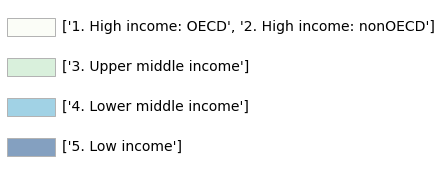

In [12]:
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mplcolors
from matplotlib import colormaps as mplcolormaps
import numpy as np
labels_list = ee.List(feature_class.reduceColumns(ee.Reducer(ee.Reducer.toList()), selected_properties).get("list")).distinct().sort().getInfo()

# Validate that `values_to_group` is either a None or a list of lists
num_colors = 0
flattened_values_to_group = []
label_color_group_dict = {}
if (values_to_group is None):
    pass
elif (type(values_to_group) == list and all([isinstance(x, list) for x in values_to_group])):
    flattened_values_to_group = sum(values_to_group, [])
    label_color_group_dict = {}
    for group_index, group_list in enumerate(values_to_group):
        for value in group_list:
            label_color_group_dict[value] = {"color_count_index" : num_colors}
        num_colors += 1
else:
    print("`values_to_group` must either be a None or a list of lists. Skipping the grouping feature.")

# Figure out how many colors we need to grab (using their index in the `css_color_dict`)
for label in labels_list:
    if label in label_color_group_dict.keys():
        pass
    else:
        label_color_group_dict[label] = {"color_count_index":num_colors}
        num_colors += 1


if color_choices == "random":
    css_color_tuples = sorted(mplcolors.CSS4_COLORS.items(), key= lambda x: x[1])
    css_color_dict = {i: {"name":tup[0], "hex":tup[1]} for i, tup in enumerate(css_color_tuples)}
    color_indices_to_use = ((
        np.linspace(0, len(css_color_dict), num_colors+1, dtype=int) + random.randint(0, len(css_color_dict)-1)
        ) % len(css_color_dict))[:-1]
    color_count_to_index_dict = {color_count_index: color_index for color_count_index, color_index in enumerate(color_indices_to_use)}
    for label_name, properties in label_color_group_dict.items():
        mod_properties = properties
        color_index = color_count_to_index_dict[properties["color_count_index"]]
        mod_properties["color_name"] = css_color_dict[color_index]["name"]
        mod_properties["color_hex_no_transparency"] = css_color_dict[color_index]["hex"]
        mod_properties["color_hex"] = css_color_dict[color_index]["hex"] + "{0:0>2X}".format(int(transparency*255))
else:
    if color_choices == "random colormap":
        color_choices = random.choice(list(mplcolormaps))
    if color_choices in list(mplcolormaps):
        # Take colors at regular intervals spanning the colormap.
        cmap = mplcolormaps[color_choices]
        colors = ["#{:0>2X}{:0>2X}{:0>2X}".format(int(c[0]*255),int(c[1]*255),int(c[2]*255)) for c in cmap(np.linspace(0, 1, num_colors))]
        for label_name, properties in label_color_group_dict.items():
            mod_properties = properties
            color_count_index = properties["color_count_index"]
            mod_properties["color_name"] = None
            mod_properties["color_hex_no_transparency"] = colors[color_count_index]
            mod_properties["color_hex"] = colors[color_count_index] + "{0:0>2X}".format(int(transparency*255))
    else:
        print("Error: provided argument for color_choices is invalid.")

def generate_color_info_dict(label_color_group_dict):
    """ Given the label_color_group_dict generated above, return a `color_info_dict`, a dictionary of dictionaries:
        the key is the "color_count_index" integer
        the value is { "matching_labels_list": a list of labels with this color
                        "color_name": (same as above), "color_hex_no_transparency":(same as above), "color_hex":(same as above)}
    """
    color_info_dict = {}
    for label_name, properties in label_color_group_dict.items():
        if properties["color_count_index"] in color_info_dict.keys():
            color_info_dict[properties["color_count_index"]]["matching_labels_list"].append(label_name)
        else:
            color_info_dict[properties["color_count_index"]] = {
                "matching_labels_list":[label_name],
                "color_name":properties["color_name"],
                "color_hex_no_transparency":properties["color_hex_no_transparency"],
                "color_hex":properties["color_hex"]
            }
    return color_info_dict


def preview_plot_colortable(label_color_group_dict):
    ''' Given the label_color_group_dict generated above, generate a preview color table'''
    cell_width = 212
    cell_height = 40
    swatch_width = 48
    margin = 12

    # Find all labels corresponding to a given `color_name`, and make that the name key for the dict item. The value is the no-transparency-hex
    color_info_dict = generate_color_info_dict(label_color_group_dict)
    colortable_text_elements = [str(val["matching_labels_list"]) for val in color_info_dict.values()]
    colortable_color_elements = [val["color_hex"] for val in color_info_dict.values()]
    colortable_pairs = list(zip(colortable_text_elements, colortable_color_elements))

    n = len(colortable_pairs)
    width = cell_width + 2 * margin
    height = cell_height * n + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width)
    ax.set_ylim(cell_height * (n-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, pair in enumerate(colortable_pairs):
        name = pair[0]
        facecolor = pair[1]
        row = i % n
        col = i // n
        y = row * cell_height
        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7
        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')
        ax.add_patch(Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=facecolor, edgecolor='0.7'))
    return fig

color_info_dict = generate_color_info_dict(label_color_group_dict)
preview_plot_colortable(label_color_group_dict)
plt.show()

In [13]:
styled_countries = geemap.ee_vector_style(countries_fc,
                                          column=selected_properties[0],
                                          labels=list(label_color_group_dict.keys()),
                                          fillColor=[x["color_hex"] for x in label_color_group_dict.values()])
legend_dict = {", ".join(x['matching_labels_list']):x["color_hex"] for x in color_info_dict.values()}

Map = geemap.Map(center=[30,0], zoom=2.5)
Map.addLayer(styled_countries, {}, "styled countries")
Map.add_legend(title=selected_properties[0], legend_dict=legend_dict)
Map

Map(center=[30, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
Map = geemap.Map()
styled_countries = geemap.ee_vector_style(countries_fc, column="INCOME_GRP",
                                          labels="")
Map.addLayer(styled_countries, {}, "Countries Feature Collection",)
Map